# Simulation of $Z_2$ gauge theory including readout-error mitigation

**Date created:** 03/24/2022

**Last edited:** 03/24/2022

**Authors:**
- Clement Charles ()
- Florian Herren (Fermilab, fherren@fnal.gov)
- Sara Starecheski ()
- Ruth Van de Water (Fermilab, ruthv@fnal.gov)

**Description:**

- Import modules
- Read in input parameters from file
- Get IBM provider & select backend
- Build circuit using function from `Trotterization` moudule
- Run simulation
- Save data to cloud

## Import modules

_Clean up tomorrow b/c I'm sure that we're not using all of them!_

In [16]:
#Standard modules
import numpy as np
from numpy import pi,sum
import matplotlib.pyplot as plt

#Qiskit
from qiskit import IBMQ, QuantumCircuit, transpile, QuantumRegister
from qiskit.providers.ibmq import RunnerResult
from qiskit.providers.aer import noise
from qiskit.providers.models import BackendProperties
from qiskit.providers.ibmq.runtime.runtime_job import RuntimeJob
from qiskit.providers.ibmq.runtime.runtime_program import ParameterNamespace
from qiskit.providers.ibmq.api.clients.runtime import RuntimeClient
from qiskit.providers.ibmq import least_busy
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import array_to_latex, plot_histogram

#Personal modules
import Trotterization
import Analysis


## Define functions

_Will replace with importing from module_

To-do:

- Import circuit-building functions from modules `Trotterization.py`, `Z2gates.py`, and `pauli_twirling.py` written by Elizabeth, Erik, & Norman.
- Combine `get_mean_fermion_number()` and `get_bootstrap_error()` into a single function tomorrow b/c there's so much reduncancy!_
- Create new module `save_results.py` (or something similar) to hold functions for automatically adding results & `JSON` files to cloud database.
- Create new module `analysis.py` to hold function to caculate mean fermion number, apply post-selection, _etc._  
- Use Elizabeth & Norman's code to build circuit

In [3]:
def gauge_kinetic(epsilon):
    circuit=QuantumCircuit(1)
    circuit.rx(-epsilon/2,0)
    U_kg = circuit.to_gate()
    U_kg.name = "U$_{Kg}$"
    return U_kg

def fermion_mass(epsilon,mass,eta):
    circuit=QuantumCircuit(1)
    circuit.rz(-epsilon*mass * eta,0)
    U_m = circuit.to_gate()
    U_m.name = "U$_m$"
    return U_m

def fermion_hopping_opt2(epsilon,eta):
    circuit= QuantumCircuit(3)
    circuit.cx(0,2)
    circuit.h(0)
    circuit.cx(1,0)
    circuit.cx(0,2)
    circuit.rz(epsilon/4 * eta,0)
    circuit.rz(-epsilon/4 * eta,2)
    circuit.cx(0,2)
    circuit.cx(1,0)
    circuit.h(0)
    circuit.cx(0,2)
    U_fho2 = circuit.to_gate()
    U_fho2.name = "U$_{fho2}$"
    return U_fho2

#mean fermion number function for noisy counts 
def get_mean_fermion_number(counts):
    mean = 0
    values= list(counts.values())
    total_counts = sum(values)
    for s in counts:
        p = s[-1]
        if p == '1':
             mean = mean + (counts[s]/total_counts)
    return mean

#bootstrap error function for noisy counts
def get_bootstrap_error(counts):
    values = list(counts.values())
    total_counts = sum(values) #total counts!=nshots for mitigated results
    B = 100
    k = list(counts.keys())
    prob = [counts[a]/total_counts for a in k] #use total_counts in denominator so that probabilities sum to 1
    means = []
    for b in range(B):
        m = 0
        samples = np.random.choice(k, size=nshots, p=prob)
        for s in samples:
            p = s[-1]
            if p == '1':
                m = m + (1/nshots)
        means.append(m)
    return np.std(means)

'''
#don't need this function any more
#bootstrap error function for mitigated counts 
def get_bootstrap_error2(counts):
    values = list(counts.values())
    total=sum(values)
    B = 100
    k = list(counts.keys())
    means = []
    for b in range(B):
        m = 0
        samples = np.random.choice(k, size=nshots, p=values)
        for s in samples:
            p = s[-1]
            if p == '1':
                m = m + (1/total)
        means.append(m)
        print(f'means={means}')
    return np.std(means)
'''

'''
#don't need this (and it's buggy!)
#mean fermion number function for mitigated counts 
def get_mean_fermion_number2(counts):
    mean = 0
    for s in counts:
        p = s[-1]
        if p == '1':
            mean = mean + counts[s]
    return mean
'''

#prepare the quantum circuit for each Trotter step
def build_circuit(nqubits,T):
    qc = QuantumCircuit(nqubits, nqubits)
    qc.x(0)
    qc.h(0)
    for t in range(T):
        for n in range(0,nqubits+1,2):
            qc.append(fermion_mass(epsilon,mass,(-1)**(n/2+1)),[n])
        for l in range(1,nqubits,2):
            qc.append(gauge_kinetic(epsilon),[l])
        for n in range(0,nqubits-2,2):
            qc.append(fermion_hopping_opt2(epsilon, (-1)**(n/2)),[n,n+1,n+2])    
    qc.measure(range(nqubits), range(nqubits))
    return qc

## Fix simulation parameters

_Will replace all of this with reading from file_

To-do:

- Read in simulation parameters from input `YAML` file.
- Add parameters for Pauli twirling and Richardson smearing

In [4]:
nqubits = 3 #should be 3 or 7 for Z2 staggered simulation
epsilon = 1 #
mass = 1.0 #
tmin,tmax = 0,5 #simulation time interval
nshots = 50 #shots per simulation

Simulation = True #use simulator if True
ReadoutError = False #use readout error noise model if True

## Initialize IBM Quantum account

To-do:

- Save IBM Quantum API token so that notebook/script can be run in terminal on personal machine.

In [5]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
print(f'{type(provider)}\n')
print(f'provider: {provider}\n')
print(f'backends: {provider.backends()}')

<class 'qiskit.providers.ibmq.accountprovider.AccountProvider'>

provider: <AccountProvider for IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>

backends: [<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>, <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>, <IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-education', group

## Choose target backend for Qiskit Runtime program

If running on real machine, choose least-busy machine with sufficient qubits

_Can I generate fixed noise model from calibration matrix (or something similar)?_

In [6]:
#get/set up backend
if (Simulation):
    MachineName = 'ibmq_belem'
    backend = provider.get_backend('ibmq_qasm_simulator')
     
    if (ReadoutError):
        #backend for noise model with readout error
        noise_model = noise.NoiseModel()
        for qi in range(nqubits):
            read_err = noise.errors.readout_error.ReadoutError([[0.88, 0.12],[0.08,0.92]])
            noise_model.add_readout_error(read_err, [qi])
        noise_str = 'readout error noise model'
            
    else:
        device_backend = provider.get_backend('ibmq_belem')
        noise_model = noise.NoiseModel.from_backend(device_backend)
        noise_str = 'ibmq_belem noise model'
        
    backend.set_options(noise_model=noise_model.to_dict())
    print(f'Running on backend {backend} with {noise_str}\n') 
        
else:
    small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                      and not x.configuration().simulator 
                                      and x.status().operational==True)
    MachineName = least_busy(small_devices)
    backend = provider.get_backend(str(MachineName)) 
    
    print(f'Running on machine {MachineName}\n')

Running on backend ibmq_qasm_simulator with ibmq_belem noise model



## Define runtime program _(and inputs)_

_A lot of this will be offloaded to input file_

In [7]:
program_id = 'circuit-runner'
measurement_error_mitigation = True #correct for readout error using calibration matrix if True
memory = True #save results for each shot if True
optimization_level = 1 #1 is least optimized; 3 i's most optimized

## Invoke runtime program

_For simulator, append t_qc to t_mc and transpile/run both at the same time_

_Need to know how to get circuit diagram in sensible format to save_

_Need to know how to deal w/ file system_

In [17]:
#lists to hold information for each Trotter step
noisy_counts = [] #noisy counts
mitigated_counts = []
noisy_data_allshots = []
Ts = [] #times
mcals = [] #calibration matrix for each Trotter step

for T in range(int(tmin/epsilon),int(tmax/epsilon)):
    Ts.append(T)
    qc = build_circuit(nqubits,T)

    if (Simulation):
        #create and run circuits needed to calculate calibration matrix
        qr = QuantumRegister(nqubits)
        meas_calibs, state_labels = complete_meas_cal(qr=qr) 
        for m in meas_calibs:
            print(m)
        t_mc = transpile(meas_calibs, backend=backend)
        job_mc = backend.run(t_mc, shots=nshots)
        
        #use results to calculate calibration matrix & filter object
        meas_fitter = CompleteMeasFitter(job_mc.result(), state_labels)
        mcals.append(meas_fitter.cal_matrix)
        meas_filter = meas_fitter.filter
        
        #run target circuit
        print('qc',qc)
        t_qc = transpile(qc, backend=backend)
        job = backend.run(t_qc, shots=nshots, memory=memory, optimization_level=optimization_level)
        
    else: 
        program_inputs = {'circuits': qc,
                          'optimization_level': optimization_level,
                          'measurement_error_mitigation': measurement_error_mitigation,
                          'memory': memory,
                          'shots': nshots
                         }
        job = provider.runtime.run(program_id=program_id,
                                   options={'backend_name': backend.name()},
                                   inputs=program_inputs,
                                   result_decoder=RunnerResult
                                  )
    result=job.result()
    
    #Append noisy data to list
    noisy_counts.append(result.get_counts()) #total counts
    noisy_data_allshots.append(result.get_memory()) #results for each shot
    
    #Append mitigated counts to lisst
    if (Simulation): 
        mitigated_result = meas_filter.apply(result)
        mitigated = mitigated_result.get_counts()
        mitigated_counts.append(mitigated)
    
    else:
        mitigated = result.get_quasiprobabilities().nearest_probability_distribution()
        dict2 = {}
        for key1 in mitigated:
            key2 = (bin(key1)[2:]).zfill(nqubits)
            dict2[key2] = mitigated[key1]
        mitigated_counts.append(dict2)

         ░ ┌─┐      
q120_0: ─░─┤M├──────
         ░ └╥┘┌─┐   
q120_1: ─░──╫─┤M├───
         ░  ║ └╥┘┌─┐
q120_2: ─░──╫──╫─┤M├
         ░  ║  ║ └╥┘
  c5: 3/════╩══╩══╩═
            0  1  2 
        ┌───┐ ░ ┌─┐      
q120_0: ┤ X ├─░─┤M├──────
        └───┘ ░ └╥┘┌─┐   
q120_1: ──────░──╫─┤M├───
              ░  ║ └╥┘┌─┐
q120_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
  c5: 3/═════════╩══╩══╩═
                 0  1  2 
              ░ ┌─┐      
q120_0: ──────░─┤M├──────
        ┌───┐ ░ └╥┘┌─┐   
q120_1: ┤ X ├─░──╫─┤M├───
        └───┘ ░  ║ └╥┘┌─┐
q120_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
  c5: 3/═════════╩══╩══╩═
                 0  1  2 
        ┌───┐ ░ ┌─┐      
q120_0: ┤ X ├─░─┤M├──────
        ├───┤ ░ └╥┘┌─┐   
q120_1: ┤ X ├─░──╫─┤M├───
        └───┘ ░  ║ └╥┘┌─┐
q120_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
  c5: 3/═════════╩══╩══╩═
                 0  1  2 
              ░ ┌─┐      
q120_0: ──────░─┤M├──────
              ░ └╥┘┌─┐   
q120_1: ──────░──╫─┤M├───
     

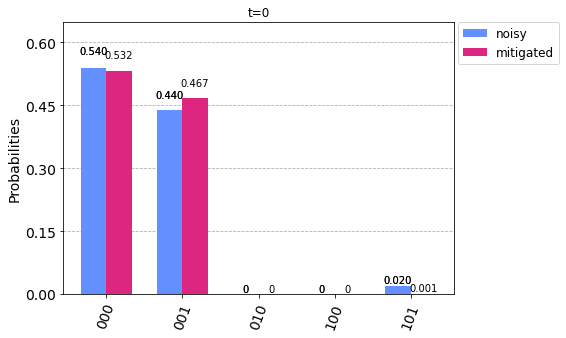

In [9]:
i=0
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(Ts[i]))

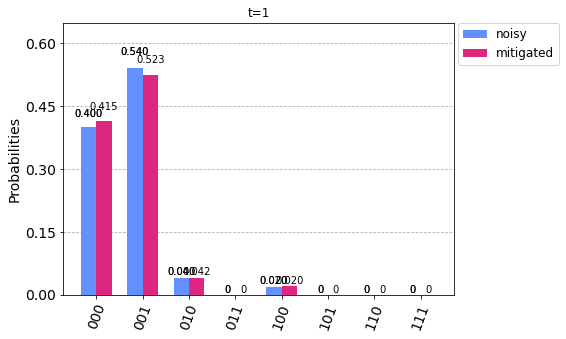

In [10]:
i=1
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(Ts[i]))

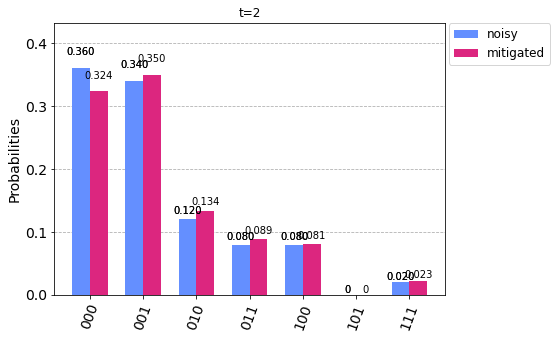

In [12]:
i=2
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(Ts[i]))

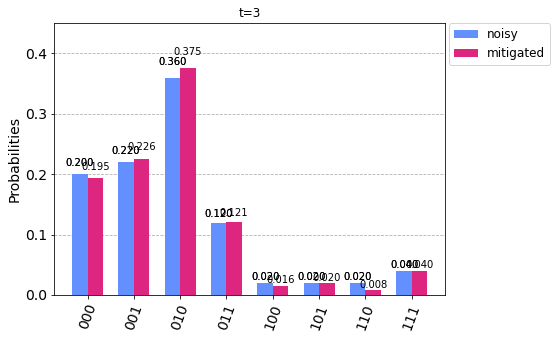

In [13]:
i=3
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(Ts[i]))

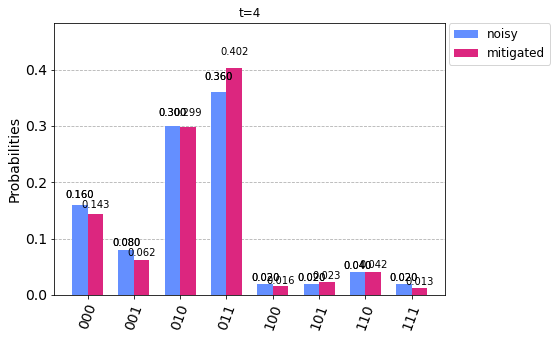

In [14]:
i=4
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(Ts[i]))

## Save raw data to cloud here

## Analyze results

_Add post-readout selection *before* 

- Clement & Sara will work on this
_Will ultimatley be separate file._
_What observables can we look at?_

- Fermion number
- Meson correlator for 2 sites?

_Need to implement readout post-selection_


mean fermion number (noisy)
T=0: nf = 0.46 +/- 0.07081
T=1: nf = 0.54 +/- 0.07424
T=2: nf = 0.44 +/- 0.07057
T=3: nf = 0.4 +/- 0.06042
T=4: nf = 0.48 +/- 0.07747

mean fermion number (corrected for readout error)
T=0: nf = 0.46805 +/- 0.06274
T=1: nf = 0.52331 +/- 0.0738
T=2: nf = 0.46164 +/- 0.06668
T=3: nf = 0.40651 +/- 0.0787
T=4: nf = 0.50031 +/- 0.07239


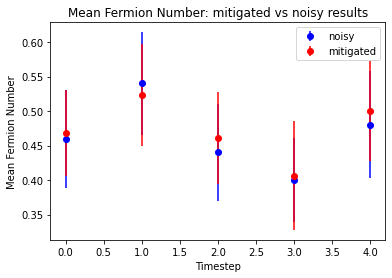

In [15]:
noisy_means = []
mitigated_means = []
noisy_errs = []
mitigated_errs = [] 

for T in Ts:
    #mean fermion number 
    noisy_means.append(get_mean_fermion_number(noisy_counts[T]))  
    mitigated_means.append(get_mean_fermion_number(mitigated_counts[T]))
    
    #bootstrap error
    noisy_errs.append(get_bootstrap_error(noisy_counts[T]))
    mitigated_errs.append(get_bootstrap_error(mitigated_counts[T])) 

print('\nmean fermion number (noisy)')
for i, nf in enumerate(noisy_means):
    print(f'T={Ts[i]}: nf = {round(nf,5)} +/- {round(noisy_errs[i],5)}')
    
print('\nmean fermion number (corrected for readout error)')
for i, nf in enumerate(mitigated_means):
    print(f'T={Ts[i]}: nf = {round(nf,5)} +/- {round(mitigated_errs[i],5)}')
    
plt.errorbar(Ts, noisy_means , yerr=noisy_errs, ls='', marker='o', color='b', label = 'noisy')
plt.errorbar(Ts, mitigated_means , yerr=mitigated_errs, ls='', marker='o', color='r', label = 'mitigated')
plt.xlabel("Timestep")
plt.ylabel("Mean Fermion Number")
plt.title("Mean Fermion Number: mitigated vs noisy results")
plt.legend()
plt.show()

In [ ]:
#load account and get provider
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
print(f'{type(provider)}\n')
print(f'provider: {provider}\n')
print(f'backends: {provider.backends()}')